In [29]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
import time

from matplotlib import pyplot as plt
import matplotlib

from image.image import Image
from control.control import Control
from control import control_funcs as c_funcs

%matplotlib inline
plt.figure(figsize=(40,40))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# This currently works by importing from the code base, to make it work with the code bellow
# move this cell all the way to the bottom and rerun all cells by click Kernel at the top then
# selecting 'Restart and Run All'

# Create a control for the images and there assocaited data to be
# stored in
basepath = 'set/the/path/to/images'

c = Control('abrasion014_abraded.jpg', 
            'abrasion014_after1.jpg',
            basepath = '/Users/adampaquette/notebooks/Abrasion Images/')

# Add a second image pair
c.add_image_pair('abrasion020_abraded.jpg', 
                 'abrasion020_after2.jpg',
                 basepath = '/Users/adampaquette/notebooks/Abrasion Images/')

# Add a second image pair
c.add_image_pair('abrasion014_marked.png', 
                 'abrasion014_cropped.png',
                 basepath = '/Users/adampaquette/notebooks/Abrasion Images/RockE/')

# Add a second image pair
c.add_image_pair('abrasion020_marked.png', 
                 'abrasion020_cropped.png',
                 basepath = '/Users/adampaquette/notebooks/Abrasion Images/RockE/')

# Apply normalization to each image pair
c.apply_func(c_funcs.normalize_func)

# Create a lab image for the images in the data frame
c.apply_func(c_funcs.convert_func, from_image = 'orig_image_data', to_image = 'lab_image_data', 
             conversion_type = cv2.COLOR_BGR2LAB)

c.apply_func(c_funcs.convert_func, from_image = 'orig_image_data', to_image = 'rgb_image_data', 
             conversion_type = cv2.COLOR_BGR2RGB)

# Apply the subtract function to each pair and generate a subtraction mask
c.apply_func(func = c_funcs.subtract_func, data = 'orig_image_data',useNorm = True)

c.apply_func(func = c_funcs.color_segment_func, rock_type = 'RockE')

In [35]:
start = time.clock()
c.apply_func(func = c_funcs.analyze_mask_func, mask = 'color_mask', mask_type = 'pixel', buffer = 3, step = 3)
end = time.clock()
print(end - start)

20.33782599999995


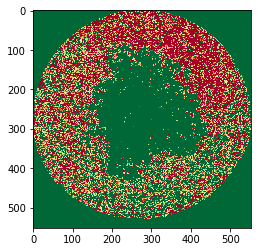

In [36]:
dataframe_idx = 2
before_image = c.dataframe.iloc[dataframe_idx ]['before_image']
after_image = c.dataframe.iloc[dataframe_idx ]['after_image']
plt.imshow(after_image['analyzed_image'], cmap = "RdYlGn", interpolation = 'nearest')

In [33]:
start = time.clock()
c.apply_func(func = c_funcs.analyze_mask_func, mask = 'color_mask', mask_type = 'block', buffer = 3, step = 3)
end = time.clock()
print(end - start)

72.72968100000003


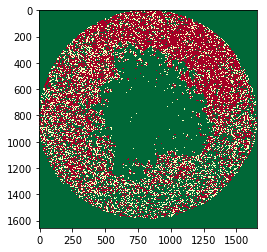

In [34]:
dataframe_idx = 2
before_image = c.dataframe.iloc[dataframe_idx ]['before_image']
after_image = c.dataframe.iloc[dataframe_idx ]['after_image']
plt.imshow(after_image['analyzed_image'], cmap = "RdYlGn", interpolation = 'nearest')